## **Data Processing**

**What is data Processing?**

Data processing is the process where make data structured in a which can be feeded to model to predict the target.

**Steps**

* We wil look for the feature and display the features.
* We will scale the data using sklearn.preprocessing.StandardScaler.
* We will not create Pipeline Classes as the data does not have to much feature
* Then we will go to model building.

**Importing all the basic library**

In [1]:
# all the basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# these are all the mertics to evaluate the model
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

# all the prepocessing classes and functions
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# all the models 
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

import warnings
warnings.filterwarnings('ignore')

**Loading the datasets<br> We will use only 16-03-2022 Data to make the model**

In [2]:
df = pd.read_csv('data/clean_data_20220316.csv')

In [3]:
df.head()

,Unnamed: 0,coin,symbol,price,1h,24h,7d,24h_volume,mkt_cap,Liquidity_Ratio,volatility
0,0,Bitcoin,BTC,40859.460000,0.022,0.030,0.055,35390763321,770991461396,0.045903,Stable
1,1,Ethereum,ETH,2744.410000,0.024,0.034,0.065,19748695312,327104429349,0.060374,Stable
2,2,Tether,USDT,1.000000,-0.001,-0.001,0.000,57934969077,79965155138,0.724503,High
3,3,BNB,BNB,383.430000,0.018,0.028,0.004,1395853984,64043816800,0.021795,Stable
4,4,USD Coin,USDC,0.999874,-0.001,0.000,-0.000,3872273611,52222137400,0.074150,Stable


We can see that we have no usefull columns named = ["Unnamed: 0", "coin", "symbol", "price"].<br>
* We will drop the string columns cause they do not have relation and help in model building.
* Droping price columns because it does not show the coin feature as market_cap shows it better


In [4]:
drop_cols = ["Unnamed: 0", "coin", "symbol", "price"]
for column in drop_cols:
    df.drop(column, inplace=True, axis=1)
    print(f"Column {column} is dropped.")

Column Unnamed: 0 is dropped.
Column coin is dropped.
Column symbol is dropped.
Column price is dropped.


In [5]:
df.head()

,1h,24h,7d,24h_volume,mkt_cap,Liquidity_Ratio,volatility
0,0.022,0.030,0.055,35390763321,770991461396,0.045903,Stable
1,0.024,0.034,0.065,19748695312,327104429349,0.060374,Stable
2,-0.001,-0.001,0.000,57934969077,79965155138,0.724503,High
3,0.018,0.028,0.004,1395853984,64043816800,0.021795,Stable
4,-0.001,0.000,-0.000,3872273611,52222137400,0.074150,Stable


**Handling Duplicates**

In [6]:
df.duplicated().sum()

np.int64(0)

### Type of Features

**Numeric Features**

In [7]:
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print('Num of Numerical Features :', len(num_features), num_features)

Num of Numerical Features : 6 ['1h', '24h', '7d', '24h_volume', 'mkt_cap', 'Liquidity_Ratio']


**Categorical Features**

In [8]:
# the one categorical feature which is displayed in output is not feature it is target for our problem statement
cat_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print('Num of Categorical Features :', len(cat_features), cat_features)

Num of Categorical Features : 1 ['volatility']


Now we will create X and y in test and train the transform the data

### Split into Train and test data

- **Do you know why we split the train and test dataset?**
> The train test split technique can be used for classification and regression problems to test machine learning algorithms. The procedure takes the given dataset and splits it into two subsets: ```Training data/train set:``` it is used to train the algorithm and fit the machine learning model
then we have ```test data/test set``` which is basically a different data for which we know the values but this data was never shown to the model before. Thus if the model after training is performing good on test set as well then we can say that the Machine Learning model is good.

In [9]:
X = df.drop('volatility', axis=1)
y = df['volatility']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scale_cols = ["24h_volume", "mkt_cap"]
passthrough_cols = ["Liquidity_Ratio", "1h", "24h", "7d"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), scale_cols),
        ("passthrough", "passthrough", passthrough_cols)
    ]
)

We have seen that 24h_volumn and market_cap have huge values so we will scale them and other columns no need to transform as they are in short range

In [10]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

We have tranformed features

now we will transform y using LabelEncoder

In [11]:
encoder = LabelEncoder()

y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

### **Outlier Treatment**
* We will not do outlier treatment as the model is predicting the coin stablity which depends on the extreme values. So there is no point to treat outlier in our case as it will directly impact model performance

## **Model Building**

In [12]:
# we use different model and evaluated them which give best result then we will hypertune them
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Decision Tree": DecisionTreeClassifier(),
        "Naive Bayes": GaussianNB(),
        "SVM": SVC(),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", verbosity=0),
        "CatBoost": CatBoostClassifier(verbose=0),
        "RandomForestClassifier": RandomForestClassifier(),
        "AdaBoostClassifier": AdaBoostClassifier(),
    }

    results = {}

    for name, model in models.items():
        print(f"\n--- Training {name} ---")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {acc:.4f}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))

        results[name] = acc

    print("\n=== Summary of Results ===")
    for name, acc in results.items():
        print(f"{name}: {acc:.4f}")
train_and_evaluate_models(X_train, X_test, y_train, y_test)


--- Training Logistic Regression ---
Accuracy: 0.7800
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        20
           1       0.76      0.97      0.85        35
           2       0.76      0.76      0.76        45

    accuracy                           0.78       100
   macro avg       0.84      0.74      0.76       100
weighted avg       0.80      0.78      0.77       100


--- Training Decision Tree ---
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        35
           2       1.00      1.00      1.00        45

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100


--- Training Naive Bayes ---
Accuracy: 0.8200
Classification Report:
              prec

Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        35
           2       1.00      1.00      1.00        45

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100


--- Training CatBoost ---
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        35
           2       1.00      1.00      1.00        45

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100


--- Training RandomForestClassifier ---
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   supp

=== Summary of Results ===

Logistic Regression: 0.7800

Decision Tree: 1.0000

Naive Bayes: 0.8200

SVM: 0.5300

XGBoost: 1.0000

CatBoost: 1.0000

RandomForestClassifier: 1.0000

AdaBoostClassifier: 1.0000<br>

From the summary table we can see model like XGBoost, CatBoost and Decission tree, RandomForest, AdaBoost working very well without need of hyperparameter training


For now we will use XGBoost as of our model without hypertuneing as it works very well and it is best Extreme Gradient Boosting algorithms.

### So we got our best parameters. Let's now train the model with those parameters.

In [13]:
best_model =  XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss", 
    verbosity=0
)

**Initialize model with best parameters**

In [14]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test,y_pred)
cr = classification_report(y_test,y_pred)

print("XGBoost Classifier")
print ("Accuracy Score value: {:.4f}".format(score))
print (cr)

XGBoost Classifier
Accuracy Score value: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        35
           2       1.00      1.00      1.00        45

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



## Confusion matrix of the model
- **What is confusion matrix ?**
> The confusion matrix is a matrix used to determine the performance of the classification models for a given set of test data. It can only be determined if the true values for test data are known. The matrix itself can be easily understood, but the related terminologies may be confusing.

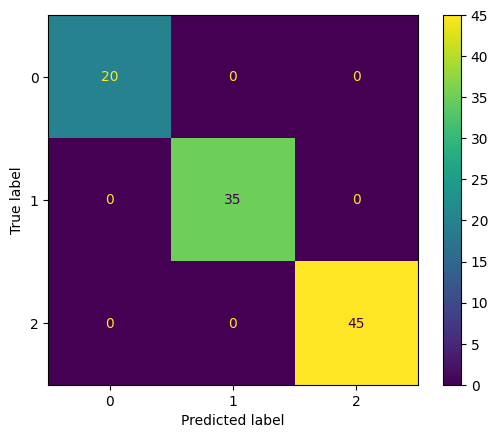

In [15]:
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

- **Reports**

**We can see, that the model performed pretty well.**
- we have used XGBoost Classifier as it performed well also other model performed well.
- We got a good accuracy while predicting the test dataset.